In [2]:
import skimage.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import diff_classifier.aws as aws
from skimage.filters import roberts, sobel, scharr, prewitt, median, rank
from skimage import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk, reconstruction
#from skimage.transform import EuclideanTransform
from scipy.ndimage.morphology import distance_transform_edt as EuclideanTransform
from scipy.ndimage.morphology import binary_fill_holes as fill_holes
import diff_register.im_process as imp

In [2]:
to_track = []
result_futures = {}

remote_folder = 'Cell_Studies/10_16_18_cell_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 5
types = ['PS', 'PEG']
slices = [1, 2]

for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            #to_track.append('100x_0_4_1_2_gel_{}_bulk_vid_{}'.format(vis, num))
            to_track.append('{}_{}_XY{}'.format(typ, slic, num))

In [6]:
def binary_BF(image, meanse=disk(10), edgefilt='prewitt', opense=disk(10),
          fill_first=False, bi_thresh=0.000025, tophatse=disk(20)):
    
    #convertim = img_as_ubyte(image)
    meanim = rank.mean(image, meanse)
    if edgefilt is 'prewitt':
        edgeim = prewitt(meanim)
    elif edgefilt is 'sobel':
        edgeim = sobel(meanim)
    elif edgefilt is 'scharr':
        edgeim = scharr(meanim)
    elif edgefilt is 'roberts':
        edgeim = roberts(meanim)
    
    closeim = closing(edgeim, opense)
    openim = opening(closeim, opense)
    if fill_first:
        seed = np.copy(openim)
        seed[1:-1, 1:-1] = openim.max()
        mask = openim
        filledim = reconstruction(seed, mask, method='erosion')
        binarim = filledim > bi_thresh
    else:
        binarim = openim > bi_thresh*np.mean(openim)
        seed = np.copy(binarim)
        seed[1:-1, 1:-1] = binarim.max()
        mask = binarim
        filledim = reconstruction(seed, mask, method='erosion')

    tophim = filledim - closing(white_tophat(filledim, tophatse), opense)>0.01

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
    ax[0][0].imshow(image, cmap='gray')
    ax[0][1].imshow(meanim, cmap='gray')
    ax[0][2].imshow(edgeim, cmap='gray', vmax=4*np.mean(edgeim))
    ax[0][3].imshow(closeim, cmap='gray', vmax=4*np.mean(closeim))
    ax[1][0].imshow(openim, cmap='gray', vmax=4*np.mean(openim))
    ax[1][1].imshow(binarim, cmap='gray')
    ax[1][2].imshow(filledim, cmap='gray')
    ax[1][3].imshow(tophim, cmap='gray')
    for axes in ax:
        for axe in axes:
            axe.axis('off')
    fig.tight_layout()
    
    return tophim

In [7]:
def BF_cell_features(prefix, folder, bucket='ccurtis.data'):
    
    ffilename = 'features_{}.csv'.format(prefix)
    mfilename = 'msd_{}.csv'.format(prefix)
    bffilename = 'BF_cells_{}.tif'.format(prefix)
    biim = 'bi_BF_cells_{}.tif'.format(prefix)
    bimages = 'biproc_BF_cells_{}.png'.format(prefix)
    
    aws.download_s3('{}/{}'.format(folder, ffilename), ffilename, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(folder, mfilename), mfilename, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(folder, bffilename), bffilename, bucket_name=bucket)
    print('Successfully downloaded files')
    
    fstats = pd.read_csv(ffilename, encoding = "ISO-8859-1")
    msds = pd.read_csv(mfilename, encoding = "ISO-8859-1")
    bfimage = plt.imread(bffilename)
    tophimage = binary_BF(bfimage, opense=disk(12), bi_thresh=1.2, tophatse=disk(20))
    plt.savefig(bimages)
    euimage = EuclideanTransform(tophimage)+EuclideanTransform(~tophimage)
    print('Successfully performed image processing')
    
    fstats['Cell Status'] = [tophimage[2043, int(fstats.X[i])-1] if fstats.Y[i]>2044
                             else tophimage[int(fstats.Y[i]-1), int(fstats.X[i])-1] if fstats.Y[i]>0
                             else np.nan for i in range(len(fstats.X))]
    fstats['Cell Distance'] = [int(euimage[2043, int(fstats.X[i])-1]) if fstats.Y[i]>2044
                               else int(euimage[int(fstats.Y[i]-1), int(fstats.X[i])-1]) if fstats.Y[i]>0
                               else np.nan for i in range(len(fstats.X))]
    print('Successfully calculated Cell Status Params')
    
    msds['Cell Status'] = [tophimage[2043, int(msds.X[i])-1] if msds.Y[i]>2044
                           else tophimage[int(msds.Y[i]-1), int(msds.X[i])-1] if msds.Y[i]>0 
                           else np.nan for i in range(len(msds.X))]
    msds['Cell Distance'] = [euimage[2043, int(msds.X[i])-1] if msds.Y[i]>2044
                             else euimage[int(msds.Y[i]-1), int(msds.X[i])-1] if msds.Y[i]>0  
                             else np.nan for i in range(len(msds.X))]
    
    
    fstats['Membrane Xing'] = [np.sum(np.diff(msds[msds.Track_ID == i]['Cell Status'].dropna()) == True) for i in range(len(fstats.X))]
    fstats['Distance Towards Cell'] = [np.sum(np.diff(msds[msds.Track_ID == i]['Cell Distance'].dropna())) for i in range(len(fstats.X))]
    fstats['Percent Towards Cell'] = [np.mean(np.diff(msds[msds.Track_ID == i]['Cell Distance'].dropna()) > 0) for i in range(len(fstats.X))]
    print('Successfully calculated Membrane Xing Params')
    
    fstats.to_csv(ffilename, sep=',', encoding = "ISO-8859-1")
    msds.to_csv(mfilename, sep=',', encoding = "ISO-8859-1")
    plt.imsave(biim, tophimage, cmap='gray')
    
    aws.upload_s3(ffilename, '{}/{}'.format(folder, ffilename), bucket_name=bucket)
    aws.upload_s3(mfilename, '{}/{}'.format(folder, mfilename), bucket_name=bucket)
    aws.upload_s3(biim, '{}/{}'.format(folder, biim), bucket_name=bucket)
    aws.upload_s3(bimages, '{}/{}'.format(folder, bimages, bucket_name=bucket))
    print('Successfully uploaded files')
    
    return fstats

Successfully downloaded files
Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


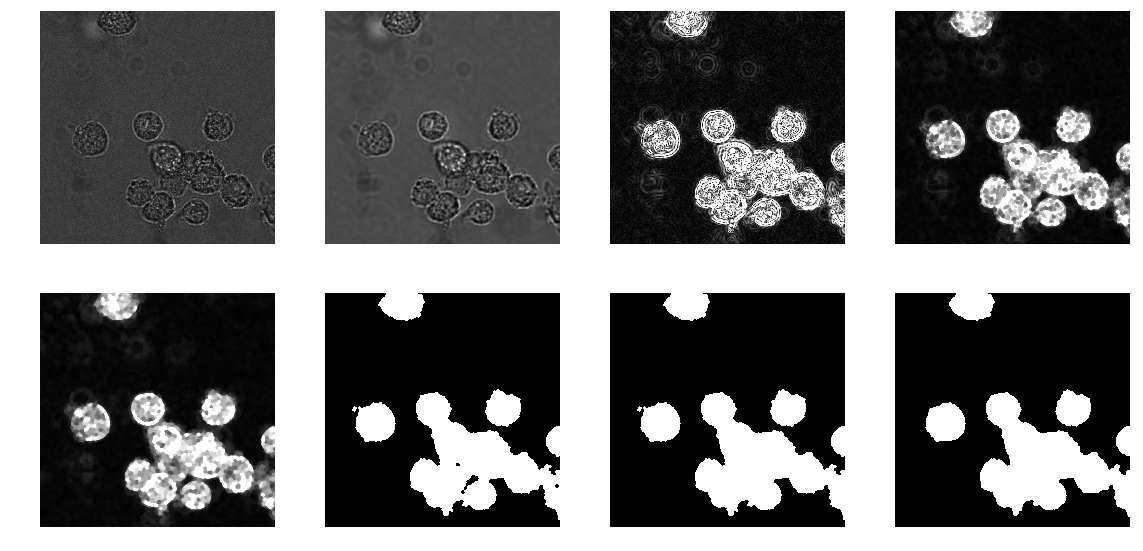

In [8]:
fstats = BF_cell_features(to_track[0], remote_folder, bucket=bucket)

Successfully downloaded files


/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


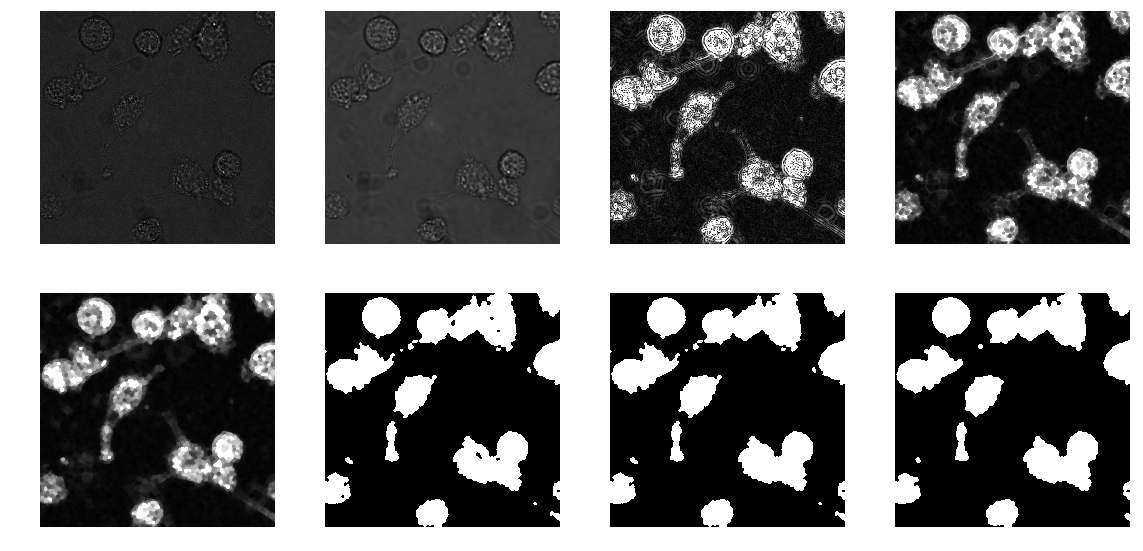

In [9]:
fstats = BF_cell_features(to_track[18], remote_folder, bucket=bucket)

Successfully downloaded files
Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


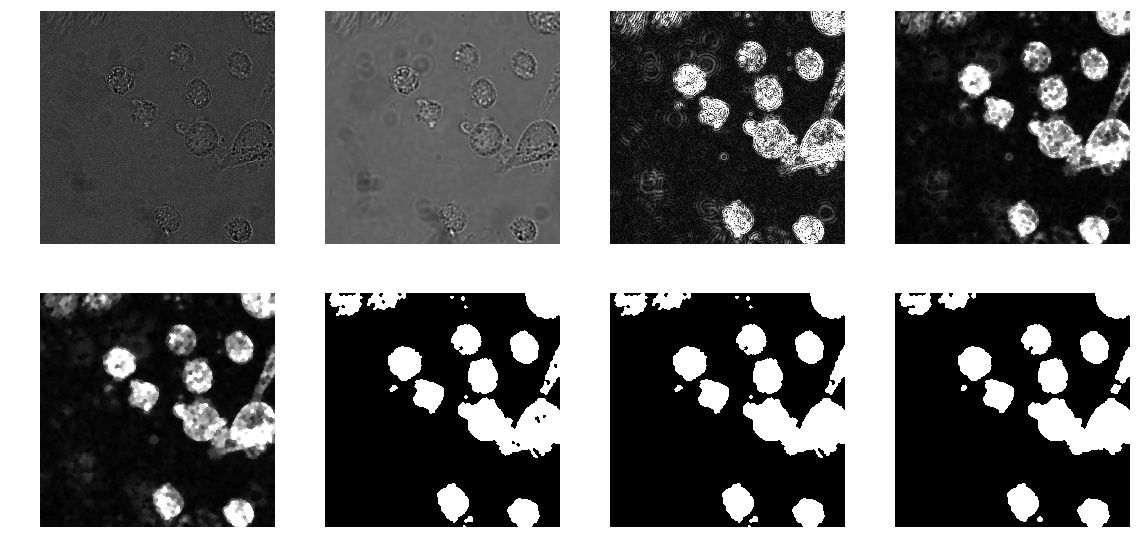

In [10]:
fstats = BF_cell_features(to_track[19], remote_folder, bucket=bucket)

Successfully downloaded files
Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


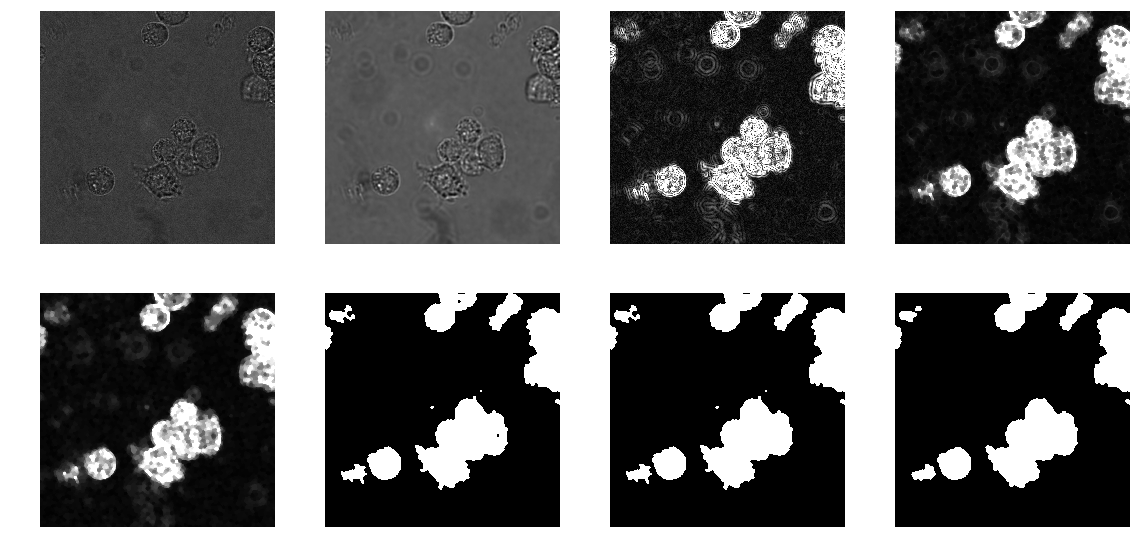

In [11]:
fstats = BF_cell_features(to_track[16], remote_folder, bucket=bucket)

Successfully downloaded files


/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


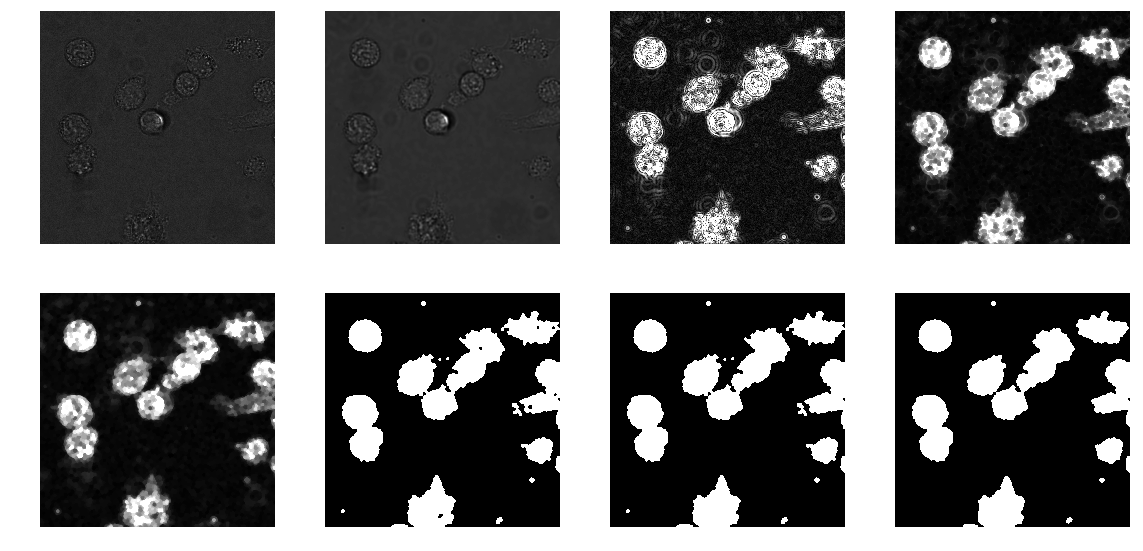

In [12]:
fstats = BF_cell_features(to_track[17], remote_folder, bucket=bucket)

Successfully downloaded files
Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


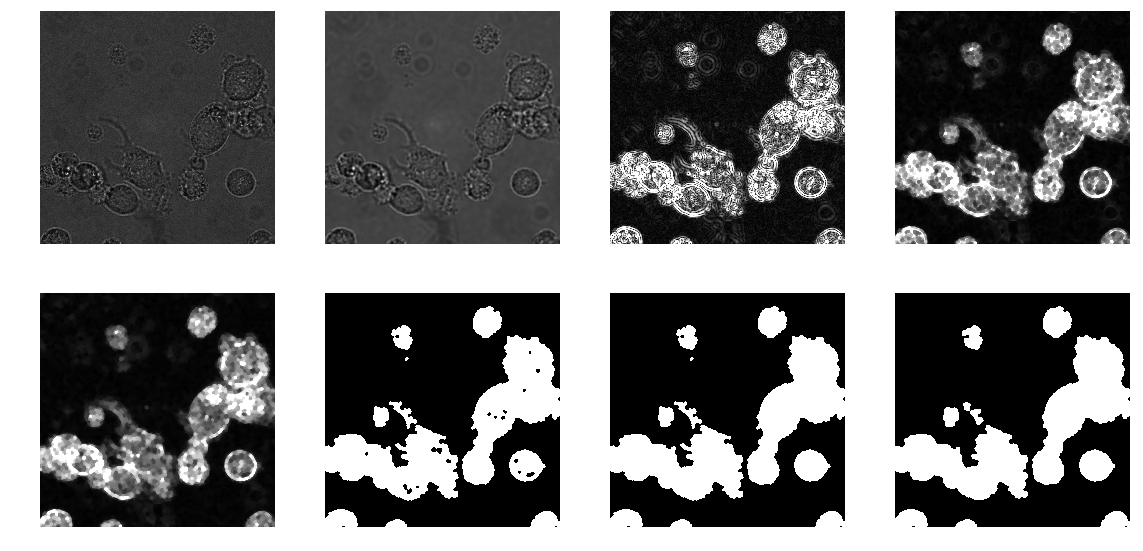

In [13]:
fstats = BF_cell_features(to_track[15], remote_folder, bucket=bucket)

Successfully downloaded files


/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


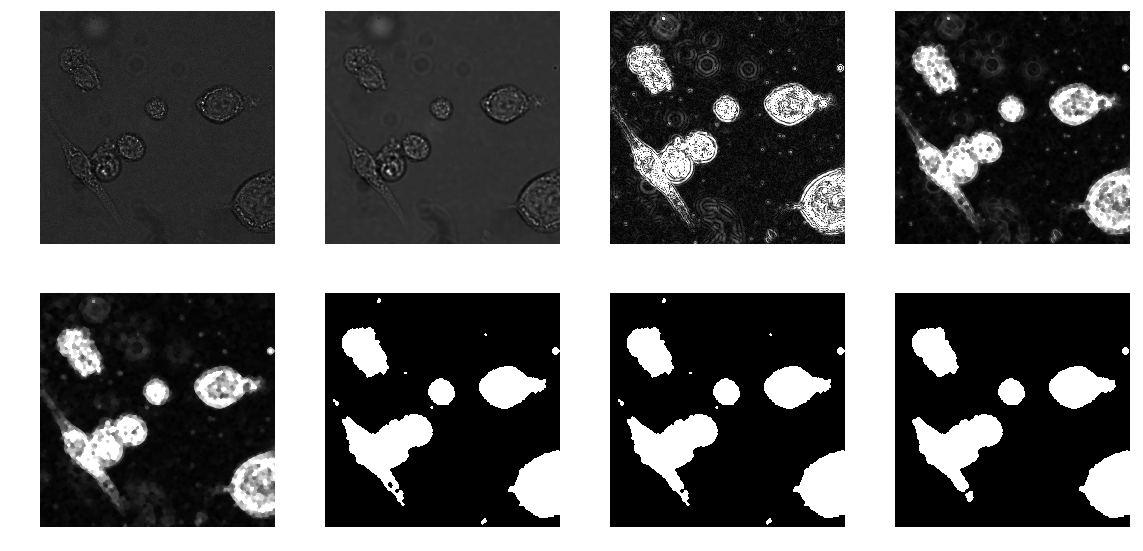

In [14]:
fstats = BF_cell_features(to_track[14], remote_folder, bucket=bucket)